# Вебинар 4. Обучение с учителем.

**План занятия**
* [Введение](#intro)
* [Шаг 1. Загрузка данных](#load)
* [Шаг 2. EDA и очистка данных](#eda)
* [Шаг 3: Очистка данных и Feature engineering](#preprocess)
* [Шаг 4. Разбиение на train / test](#split)
* [Шаг 5. Построение моделей](#model)
    * [5.1 Linear Regression](#linear)
    * [5.2 Decision tree](#tree)
    * [5.3 Random Forest](#rf)
    * [5.4 Gradient Boosting decision trees](#boost)
* [Шаг 6. Настройка и оценка финальной модели](#cross_val)
* [Шаг 7. Анализ прогнозов](#pred)
* [Шаг 8. Сохранение модели](#save)
* [Обобщение](#full)

## Введение <a class='anchor' id='intro'>

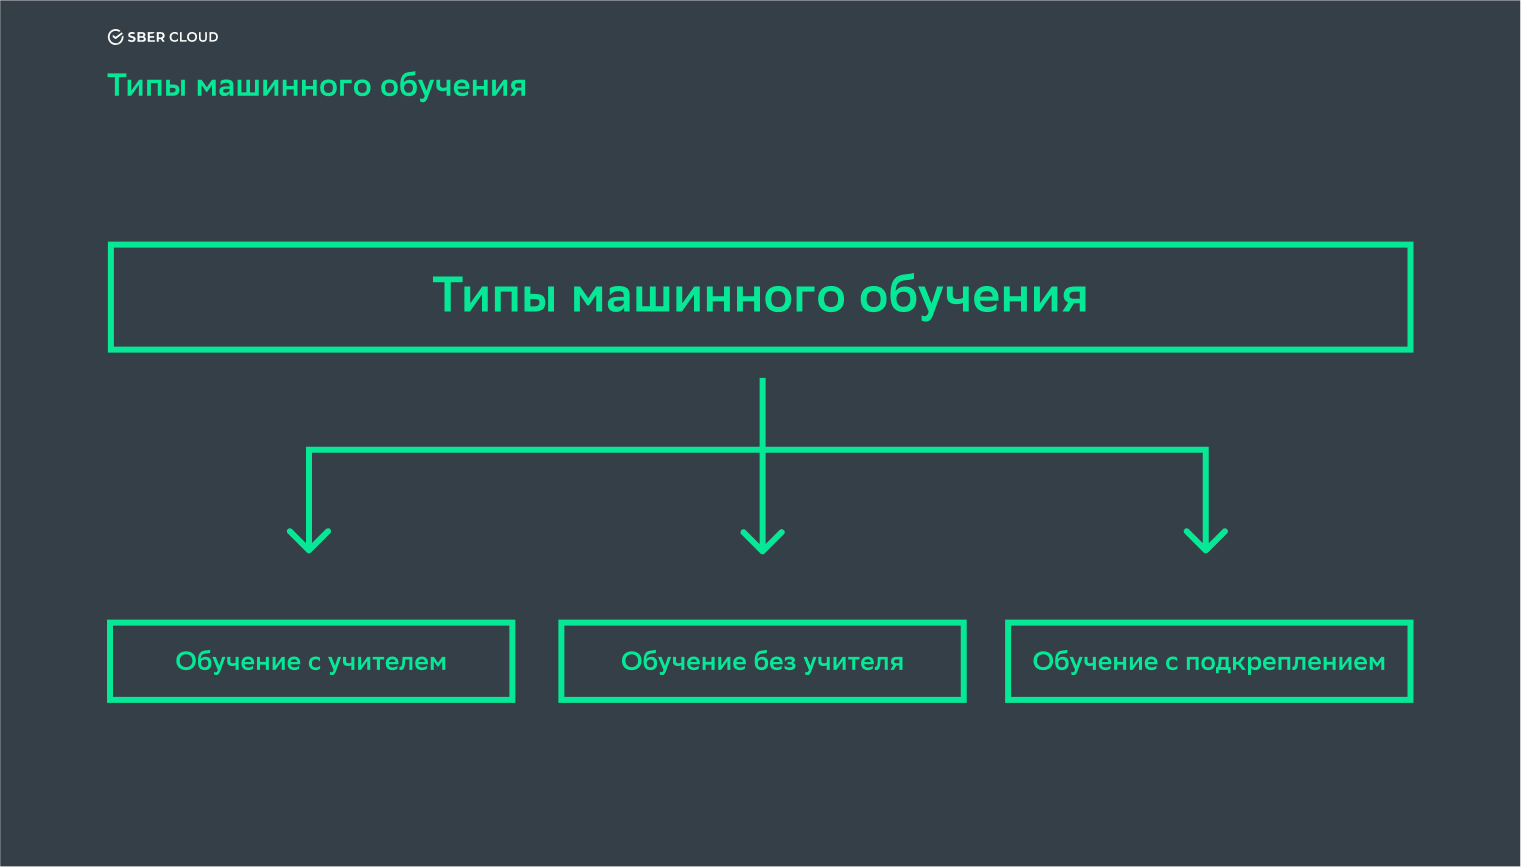

* **Обучение с учителем** = есть целевая переменная (таргет), которую мы предсказываем. Машина учится по выбранным данным. Обычно, данные отмечаются людьми. (тема сегодня)
* **Обучение без учителя** = нет целевой переменной. Машина учится не по выбранным данным. Смысл в том, что среди данных нет «правильного» ответа, машина должна найти зависимость между объектами. (следующая тема)
* **Обучение с подкреплением** = есть вознаграждение при выборе наиболее подходящего ответа. Машина учится через систему на основе вознаграждения. Этот тип машинного обучения требует использования системы вознаграждения/штрафа. Цель — вознаградить машину, когда она учится правильно, и наказать машину, когда она учится неправильно. Например, обучение машины, как научиться играть (Chess, Go)

**Supervised learning (обучение с учителем)**

Обучение с учителем — наиболее распространенный и изученный тип машинного обучения, ведь легче обучить машину с выбранными данными. В зависимости от того, что вы хотите предсказать, обучение с учителем может использоваться для решения двух типов задач: задача регрессии и задача классификации.

_Регрессия_ - таргет непрерывен
- Предсказание цен на дома
- Предсказание спроса на товары
- ...


_Классификация_ - Таргет принимает 2 (иногда k) значений
- Кредитный скоринг: вернет кредит (target=0) или нет (target=1)
- Определение вида животного по фото (0 - лев, 1 - пантера, 2 - леопард, ... , k - гепард) 
- Прогноз оценки студента по пятибалльной шкале на экзамене
- Предсказание спроса на товары
- Поиск похожих групп пользователей

---

**ЭТАПЫ Data Science проекта:**
1. Определить бизнес задачу, выбрать **бизнес метрику**
2. Перевести бизнес-задачу в ML задачу. Определить **ML метрику**
3. Понять какими **типами моделей**, можно оптимизировать данную ML метрику (линейные модели, нейросети, бустинги, неградиентные методы).
4. Для соответствующей модели выбрать **loss-функцию**:
- дифференцируема (для градиентного спуска*)
5. Какие **данные** необходимо собрать для решения?
6. Прикинуть архитектуру решения (сколько моделей - возможно разбиение задачи на подзадачи, уровни моделей - стеккинг)
7. Моделирование
8. Валидация
9. Пилотирование (best practice - AB test)
10. Внедрение

градиентный спуск - численный метод поиска максимума/минимума функции

---

**ЭТАПЫ моделирования:**
1. EDA - анализ данных (построение статистик, визуализация, поиск закономерностей) - вебинар 3
2. Очистка данных и отбор long-list факторов - вебинар 2
3. train-test split
4. Построение ML решения (в широком смысле это мб не одна модель)
5. Валидация на test

---------------------------------------------------------------------------

**Подключение библиотек и скриптов**

In [1]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

**Пути к директориям и файлам**

In [6]:
DATASET_PATH = '/content/drive/My Drive/GB/Python_libs/5. Вебинар 2 Matplotlib/housing.csv'
PREPARED_DATASET_PATH = '/content/drive/My Drive/GB/Python_libs/5. Вебинар 2 Matplotlib/housing_prepared.csv'

REPORTS_FILE_PATH = '/content/drive/My Drive/GB/Python_libs/7. Вебинар 3 Supervised learning/reports/'
SCALER_FILE_PATH = '/content/drive/My Drive/GB/Python_libs/7. Вебинар 3 Supervised learning/scaler.pkl'
MODEL_FILE_PATH = '/content/drive/My Drive/GB/Python_libs/7. Вебинар 3 Supervised learning/model.pkl'

# Шаг 1. Загрузка данных <a class='anchor' id='load'>

По **reduce_mem_usage** смотри вебинар 3

In [7]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

**Описание датасета**

Статистические данные о ряде домов в Калифорнии, основанные на переписи 1990 года.

* **longitude** - долгота
* **latitude** - широта
* **housing_median_age** - средний возраст дома
* **total_rooms** - общее количество комнат
* **total_bedrooms** - общее количество спален
* **population** - количество проживающих
* **households** - домохозяйства
* **ocean_proximity** - близость океана
* **median_income** - средний доход
* **median_house_value** - средняя стоимость дома

In [8]:
df = pd.read_csv(DATASET_PATH, sep=';')
df = reduce_mem_usage(df)
df.head()

Memory usage of dataframe is 2.83 MB
Memory usage after optimization is: 1.06 MB
Decreased by 62.5%


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,bedroom_share,population_per_room,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,median_rooms
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,14.659091,0.365909,0,0,0,1,0,2083.0
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,15.579659,0.338217,0,0,0,1,0,2083.0
2,-122.239998,37.849998,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,12.951602,0.338105,0,0,0,1,0,2083.0
3,-122.250000,37.849998,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,18.445839,0.437991,0,0,0,1,0,2083.0
4,-122.250000,37.849998,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,17.209589,0.347265,0,0,0,1,0,2083.0


In [9]:
df.dtypes

longitude               float32
latitude                float32
housing_median_age      float32
total_rooms             float32
total_bedrooms          float32
population              float32
households              float32
median_income           float32
median_house_value      float32
ocean_proximity        category
bedroom_share           float32
population_per_room     float32
<1H OCEAN                  int8
INLAND                     int8
ISLAND                     int8
NEAR BAY                   int8
NEAR OCEAN                 int8
median_rooms            float32
dtype: object

# Шаг 2. EDA и очистка данных  <a class='anchor' id='eda'>

*В этом вебинаре мы не будем останавливаться на EDA, но в проекте это сделать нужно - __смотри вебинар 3__

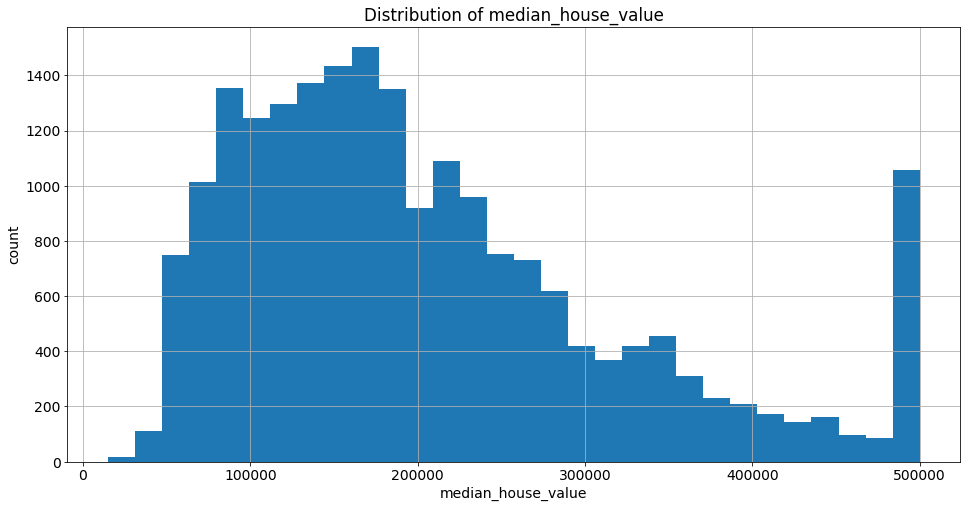

In [10]:
plt.figure(figsize = (16, 8))

df['median_house_value'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('median_house_value')

plt.title('Distribution of median_house_value')
plt.show()

In [11]:
df = df[df['median_house_value'] <= 500000].reset_index()

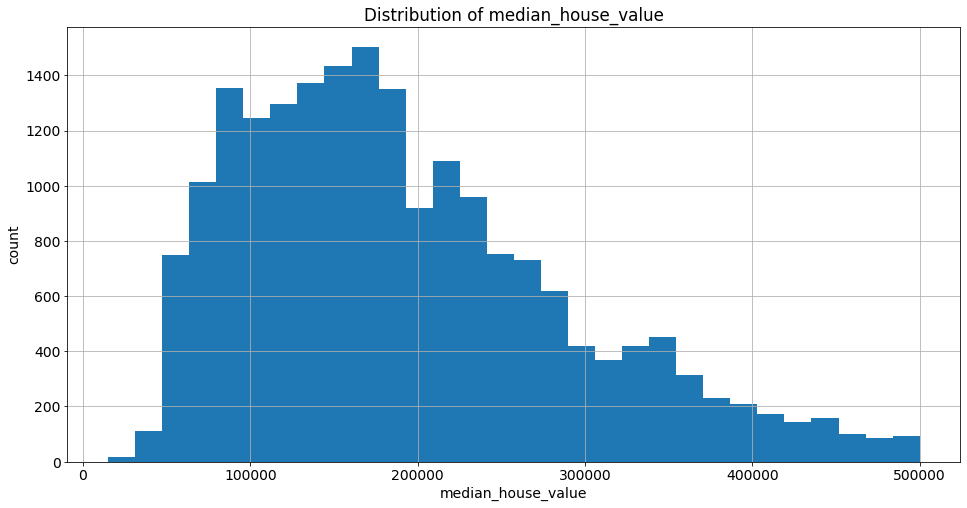

In [12]:
plt.figure(figsize = (16, 8))

df['median_house_value'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('median_house_value')

plt.title('Distribution of median_house_value')
plt.show()

# Шаг 3: Очистка данных и Feature engineering  <a class='anchor' id='preprocess'>

*Пример вы можете посметреть в вебинаре 2: __class DataPipeline__

In [13]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        # <your code>
        
    def fit(self, df):
        """Сохранение статистик"""
        # <your code>
        
    def transform(self, df):
        """Трансформация данных"""
        # <your code>

---

**Оставим признаки, которые необходимы для модели**

In [14]:
df.columns.tolist()

['index',
 'longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'bedroom_share',
 'population_per_room',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN',
 'median_rooms']

In [15]:
feature_names = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 
                 'households', 'median_income', '<1H OCEAN', 'INLAND', 'NEAR BAY', 'NEAR OCEAN']

target_name = 'median_house_value'

In [16]:
df = df[feature_names + [target_name]]
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN,median_house_value
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,1,0,452600.0
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,1,0,358500.0
2,-122.239998,37.849998,52.0,1467.0,190.0,496.0,177.0,7.2574,0,0,1,0,352100.0
3,-122.250000,37.849998,52.0,1274.0,235.0,558.0,219.0,5.6431,0,0,1,0,341300.0
4,-122.250000,37.849998,52.0,1627.0,280.0,565.0,259.0,3.8462,0,0,1,0,342200.0


**Стандартизация признаков** 

In [18]:
feature_names_for_stand = df[feature_names].select_dtypes(include=['float32', 'float16']).columns.tolist()
feature_names_for_stand

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [19]:
# MinMaxScaler() Для каждой фичи x делает: (x - min) / (max - min) -> [0, 1]
# StandardScaler() Для каждой фичи х делает: (x - mean) / std      -> mean = 0, std = 1

scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names_for_stand])

In [20]:
stand_features

array([[-1.3296409 ,  1.0366442 ,  1.0243417 , ..., -0.98255783,
        -0.9789465 ,  2.9603806 ],
       [-1.3246547 ,  1.0273402 , -0.6042318 , ...,  0.85655695,
         1.6615938 ,  2.9452236 ],
       [-1.3346232 ,  1.0226873 ,  1.920057  , ..., -0.8286348 ,
        -0.8458758 ,  2.2803533 ],
       ...,
       [ 0.6195371 , -1.0799824 ,  1.920057  , ..., -0.618981  ,
        -0.5562513 , -0.1822132 ],
       [ 0.6195371 , -1.0753312 ,  1.920057  , ..., -0.96575016,
        -0.8902327 , -0.5990307 ],
       [ 0.53977364, -1.0334638 ,  0.04719759, ..., -0.8940963 ,
        -0.8563127 , -0.6830311 ]], dtype=float32)

In [21]:
stand_features.shape

(19675, 8)

In [22]:
df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [23]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN,median_house_value
0,-1.329641,1.036644,1.024342,-0.797584,-0.974311,-0.982558,-0.978947,2.960381,0,0,1,0,452600.0
1,-1.324655,1.027340,-0.604232,2.053478,1.349771,0.856557,1.661594,2.945224,0,0,1,0,358500.0
2,-1.334623,1.022687,1.920057,-0.528477,-0.829205,-0.828635,-0.845876,2.280353,0,0,1,0,352100.0
3,-1.339609,1.022687,1.920057,-0.616957,-0.722159,-0.773789,-0.736288,1.252288,0,0,1,0,341300.0
4,-1.339609,1.022687,1.920057,-0.455126,-0.615113,-0.767596,-0.631919,0.107935,0,0,1,0,342200.0


In [24]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN,median_house_value
count,1.967500e+04,19675.000000,1.967500e+04,1.967500e+04,1.967500e+04,1.967500e+04,1.967500e+04,1.967500e+04,19675.000000,19675.000000,19675.000000,19675.000000,19675.000000
mean,4.369967e-07,-0.000002,2.870481e-07,5.223700e-08,1.896746e-08,1.702194e-07,-1.714978e-08,-7.932643e-08,0.438018,0.331131,0.106429,0.124168,192477.734375
std,1.000020e+00,1.000020,1.000032e+00,1.000024e+00,1.000022e+00,1.000024e+00,1.000026e+00,1.000024e+00,0.496156,0.470632,0.308394,0.329781,97711.296875
min,-2.386481e+00,-1.447485,-2.232805e+00,-1.200097e+00,-1.276418e+00,-1.264750e+00,-1.302491e+00,-2.023152e+00,0.000000,0.000000,0.000000,0.000000,14999.000000
25%,-1.095340e+00,-0.800867,-8.485179e-01,-5.417721e-01,-5.699162e-01,-5.544041e-01,-5.719066e-01,-7.323231e-01,0.000000,0.000000,0.000000,0.000000,116600.000000
50%,5.298051e-01,-0.642702,4.719759e-02,-2.332395e-01,-2.464003e-01,-2.368273e-01,-2.353160e-01,-1.443843e-01,0.000000,0.000000,0.000000,0.000000,173800.000000
75%,7.840465e-01,0.966865,6.171983e-01,2.293302e-01,2.531465e-01,2.550187e-01,2.734837e-01,5.769104e-01,1.000000,1.000000,0.000000,0.000000,248200.000000
max,2.618566e+00,2.929979,1.920057e+00,1.682500e+01,1.405015e+01,3.029743e+01,1.456162e+01,7.211282e+00,1.000000,1.000000,1.000000,1.000000,500000.000000


### Сохранение  датасета

In [ ]:
#df.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8', sep=';')

# Шаг 4. Разбиение на train / test  <a class='anchor' id='split'>

In [28]:
X = df[feature_names]
y = df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Шаг 5. Построение моделей <a class='anchor' id='model'>

    
ML метрика - Mean Squared Error (**MSE**) 
    - MSE прямопропорциональна RMSE и R^2
    - MSE  удобно оптимизировать (брать производные)
    - MSE используется "под капотом" наших ML моделей



Бизнес метрика - **R^2**,

Root Mean Squared Error (**RMSE**)
    - Бизнес метрика интерпретируема
    - Понятна бизнесу
    - Ее мы показываем бизнесу
    - RMSE - насколько, в среднем, $ мы ошибаемся при предсказании цен 
    - R^2 принимает значения от 0 до 1, если 1 - все предсказания идеальны. Можно сказать, что это "точность" модели

Лучшая модель - модель с наименьшей MSE на test 

 $$MSE = \frac{1}{n}  \sum{(y - y_{pred})^2}$$

$$RMSE = \sqrt{\frac{1}{n}  \sum{(y - y_{pred})^2}}$$

$$R^2 = 1 - \frac{\frac{1}{n}\sum{(y - y_{pred})^2}}{\frac{1}{n}\sum{(y - y_{mean})^2}}$$

In [29]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

### 5.1 Linear Regression  <a class='anchor' id='linear'>

$$price_{pred} = a_0 + a_1 * households + a_2 * rooms$$

Подробное объяснение [здесь](https://codecamp.ru/blog/introduction-to-linear-regression-python/)

$$Loss = MSE = \frac{1}{n}\sum{(price - price_{pred})^2}$$

$$Loss = MSE = \frac{1}{n}\sum{(price - (a_0 + a_1 * households + a_2 * rooms))^2}$$

$dx^2 = 2x$

$d4x = 4$

Находим производные по параметрам и решим систему из 3 уравнений с 3 неизвестными:

$$\frac{dLoss}{da_0} = \frac{1}{n}\sum{2*(price-(a_0 + a_1 *households + a_2*rooms)) * 1} = 0 $$  
$$\frac{dLoss}{da_1} = \frac{1}{n}\sum{2*(price-(a_0 + a_1 *households + a_2*rooms)) * households} = 0 $$  
$$\frac{dLoss}{da_2} = \frac{1}{n}\sum{2*(price-(a_0 + a_1 *households + a_2*rooms)) * rooms} = 0 $$  

In [30]:
np.clip([-10, 1, 100000, 1000000], a_min=10000, a_max=500000)

array([ 10000,  10000, 100000, 500000])

R2:	0.609
RMSE:	60901.319
MSE:	3708970652.116


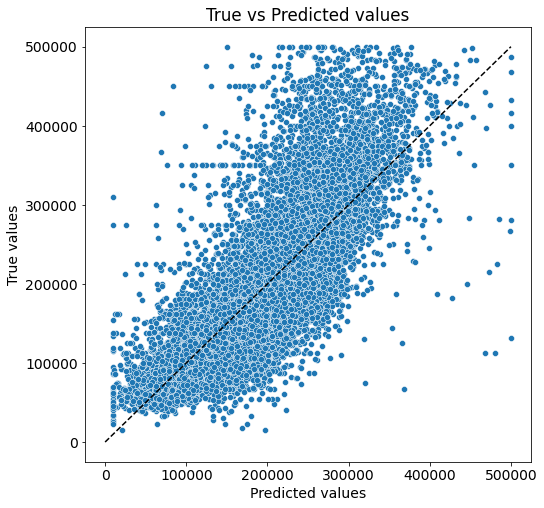

In [31]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_preds = lr_model.predict(X_train)
# Постпроцессинг
y_train_preds = np.clip(y_train_preds, a_min=10000, a_max=500000)

evaluate_preds(y_train, y_train_preds)

In [32]:
y_train_preds

array([171535.46875 , 302606.625   , 350330.75    , ..., 147432.84375 ,
       246647.359375, 161339.765625])

R2:	0.621
RMSE:	61001.491
MSE:	3721181853.179


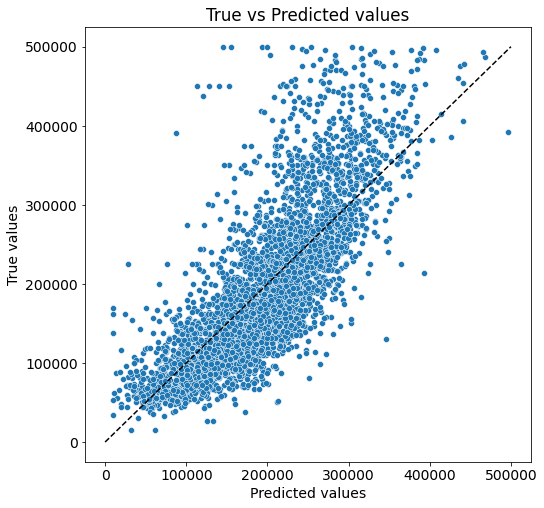

In [33]:
y_test_preds = lr_model.predict(X_test)

# Постпроцессинг
y_test_preds = np.clip(y_test_preds, a_min=10000, a_max=500000)

evaluate_preds(y_test, y_test_preds)

R2:	0.619
RMSE:	61128.934
MSE:	3736746500.0


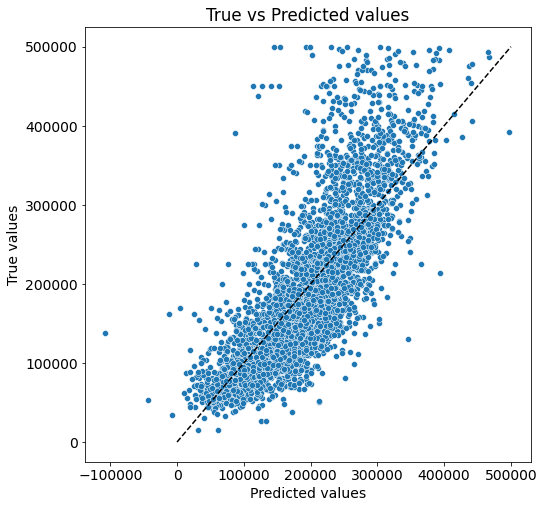

In [35]:
# Зачем обрезать np.clip()

y_test_preds = lr_model.predict(X_test)

evaluate_preds(y_test, y_test_preds)

### 5.2 Decision tree  <a class='anchor' id='tree'>

Подробнее можно почитать [здесь](https://habr.com/ru/company/ods/blog/322534/)

На примере задачи: _Сколько времени человек потратит на онлайн игры?_  (0 - 24 часа/день)

- age < 15 and is_male > 0.5 ---> 5
- age < 15 and is_male <= 0.5 ---> 0
- age >= 15 ---> 1

Decision tree может моделировать зависимости такого вида:

R2:	0.765
RMSE:	47198.031
MSE:	2227654092.973


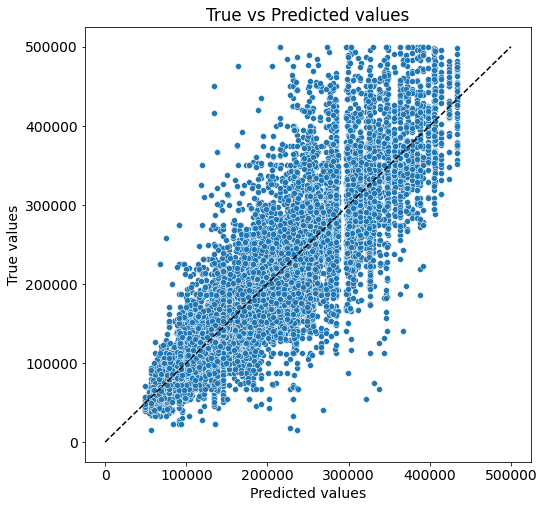

In [39]:
dt_model = DecisionTreeRegressor(criterion='mse', 
                                 max_depth=400, # глубина дерева  
                                 min_samples_leaf=30, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42)
dt_model.fit(X_train, y_train)

y_train_preds = dt_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.719
RMSE:	52487.164
MSE:	2754902420.483


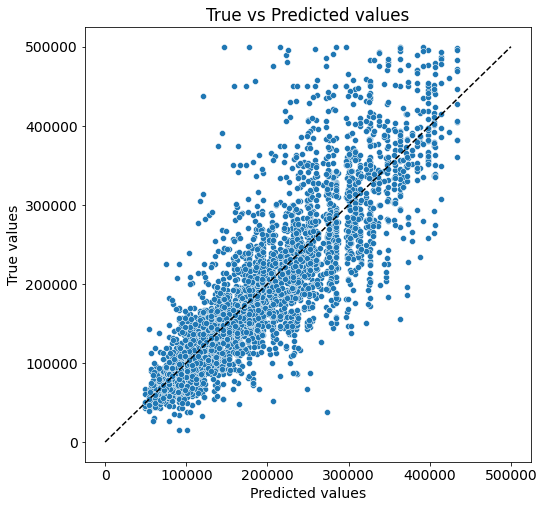

In [40]:
y_test_preds = dt_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X_train.columns, filled = True);

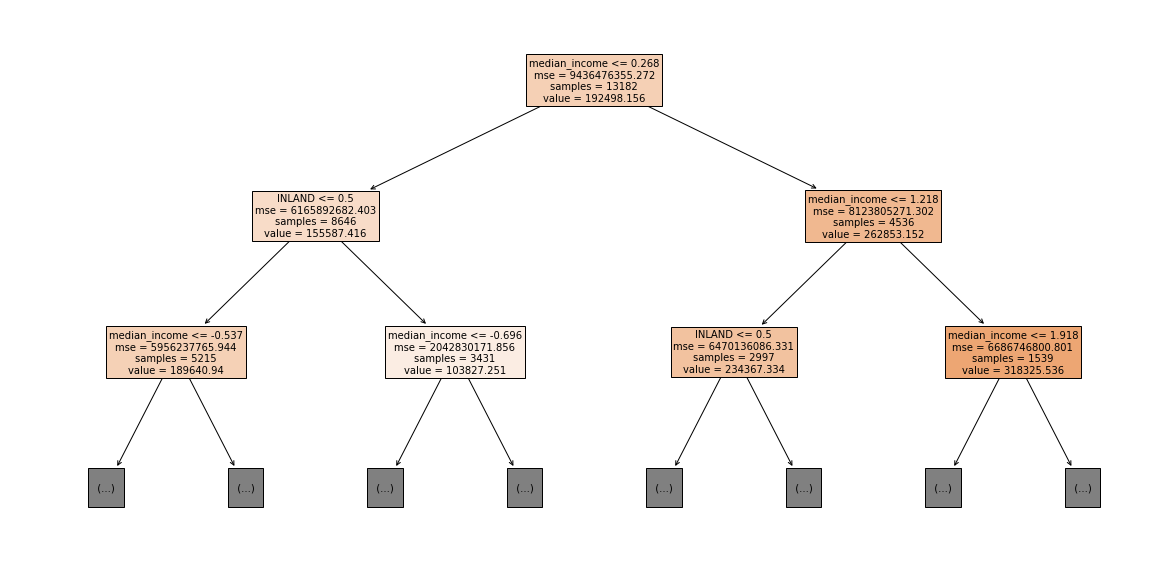

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(dt_model, feature_names=X_train.columns, filled = True, max_depth=2);

### 5.3 Random Forest  <a class='anchor' id='rf'>

Про лес подробнее можно почитать [здесь](https://towardsdatascience.com/understanding-random-forest-58381e0602d2)

Зачем нам Лес - по теореме о  [жюри присяжных](https://habr.com/ru/company/ods/blog/324402/)

**Независимо** строятся N деревьев. Их **предсказания усредняются**

Чтобы деревья получались разными добавляют элемент случайности:
- каждое дерево строят на подвыборке данных (случайно сэмплируют 70% данных)
- каждое дерево строят на подвыборке фич (случайно сэмплируют 70% фич)
- ...

Бутстрэп - выбираем из обучающей выборки k объектов с возвращением.
![image.png](attachment:image.png)
Бэггинг - Бутстрэп-агрегирование<br>
Про бэггинг и бутстрэп можно почитать [здесь](https://habr.com/ru/company/ods/blog/324402/)

R2:	0.773
RMSE:	46378.274
MSE:	2150944344.648


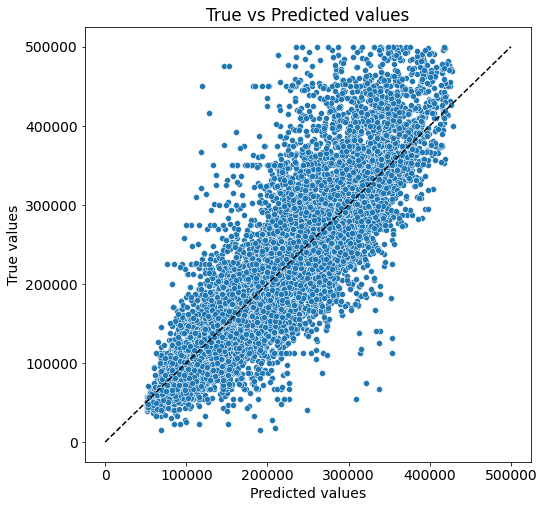

In [51]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=100, # глубина дерева  
                                 min_samples_leaf=30, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42,
                                 n_estimators=100  # кол-во деревьев
                                 )

rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.74
RMSE:	50510.958
MSE:	2551356894.938


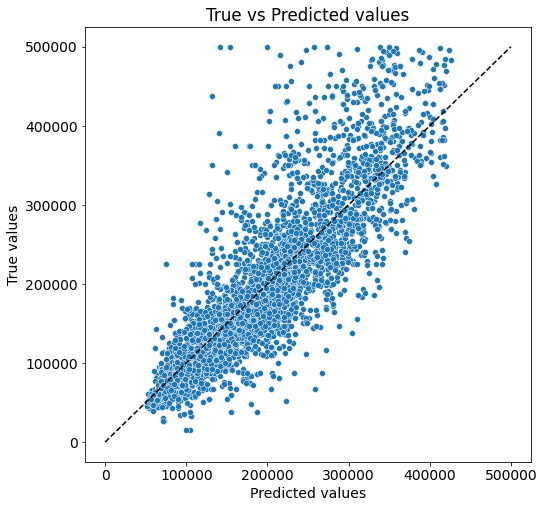

In [53]:
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

### 5.4 Gradient Boosting decision trees  <a class='anchor' id='boost'>

Подробнее можно почитать [здесь](https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d)

https://habr.com/ru/company/ods/blog/327250/

**Последовательно** строятся N деревьев: новое дерево обучается на ошибках предыдущих. **Предсказания деревьев суммируются**

In [54]:
y = np.array([10, 20, 30, 5, 10])

# Первое дерево
y_pred_1 = np.array([8, 25, 34, 10, 3])
error_1 = y - y_pred_1

error_1

array([ 2, -5, -4, -5,  7])

In [55]:
gb_pred = y_pred_1
r2(y, gb_pred)

0.7025

In [56]:
# Второе дерево: таргет = ошибки первого (error_1)
y_2 = error_1
y_pred_2 = np.array([1, -4, -2, -1, 3])

error_2 = y_2 - y_pred_2
error_2

array([ 1, -1, -2, -4,  4])

In [57]:
gb_pred = y_pred_1 + y_pred_2
r2(y, gb_pred)

0.905

In [58]:
# Третье дерево: таргет = ошибки второго (error_2)
y_3 = error_2
y_pred_3 = np.array([0, -1, -1, -1, 1])

error_3 = y_3 - y_pred_3
error_3

array([ 1,  0, -1, -3,  3])

In [59]:
gb_pred = y_pred_1 + y_pred_2 + y_pred_3
r2(y, gb_pred)

0.95

---

R2:	0.866
RMSE:	35658.619
MSE:	1271537095.883


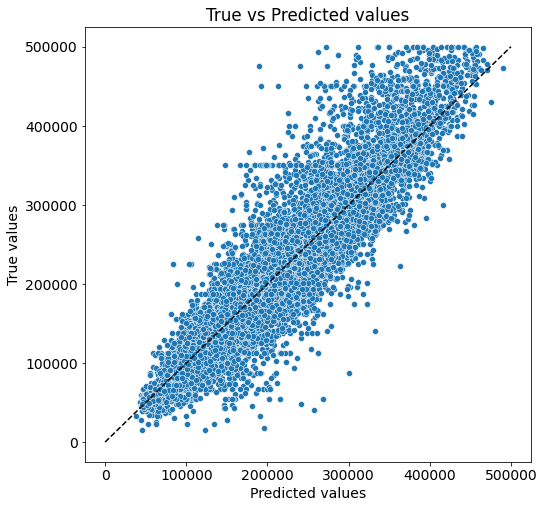

In [60]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=30,
                                     random_state=42,  
                                     n_estimators=100)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.802
RMSE:	44070.538
MSE:	1942212346.312


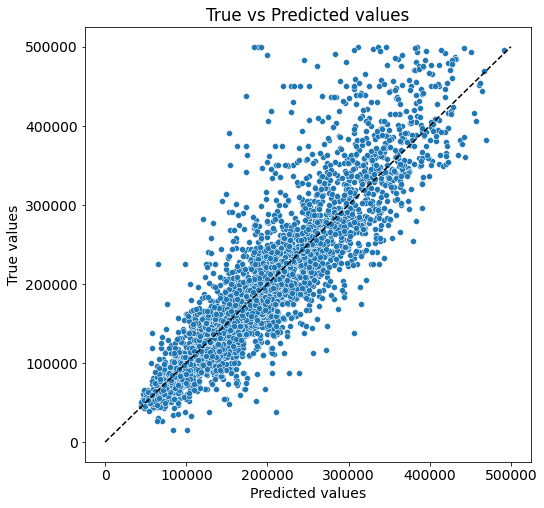

In [61]:
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

# XGBoost lib

In [62]:
!pip install xgboost

In [64]:
import xgboost as xgb

In [73]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 7,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear', # задача регрессии
    'eval_metric': 'rmse',
    'min_child_weight':10,
    'silent': 1,
    'seed':0
}

In [70]:
X_train['OCEAN'] = X_train['<1H OCEAN']
X_test['OCEAN'] = X_test['<1H OCEAN']

del X_train['<1H OCEAN']
del X_test['<1H OCEAN']

In [71]:
xgb_train = xgb.DMatrix(X_train
                        , y_train
                        , feature_names = X_train.columns)
xgb_test = xgb.DMatrix(X_test
                        , feature_names = X_train.columns)

In [74]:
model = xgb.train(params = xgb_params
                  , dtrain = xgb_train
                  , num_boost_round = 2000
                  , verbose_eval = 10)

R2:	0.982
RMSE:	13135.323
MSE:	172536720.0


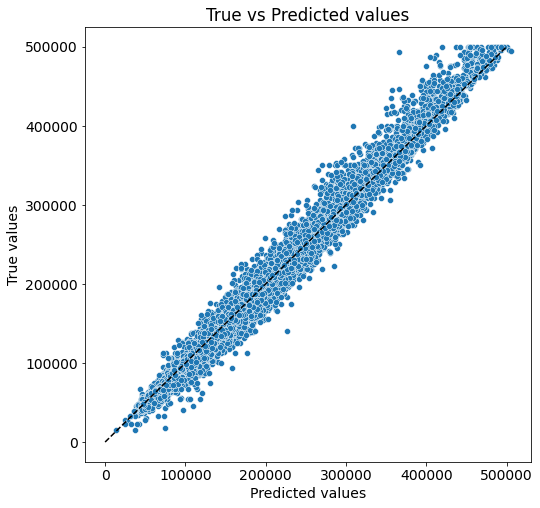

In [76]:
y_train_preds = model.predict(xgb_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.824
RMSE:	41533.04
MSE:	1724993300.0


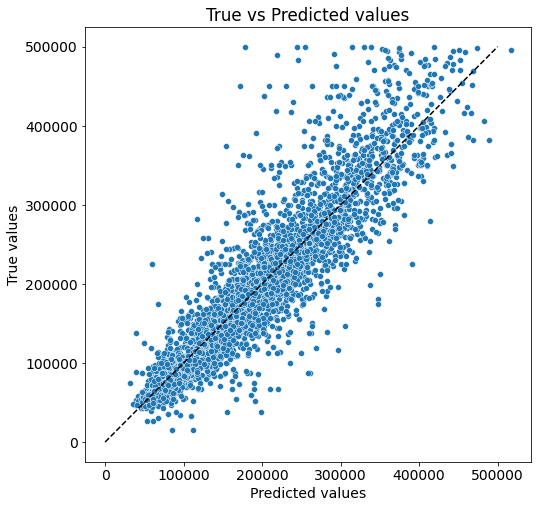

In [78]:
y_test_preds = model.predict(xgb_test)
evaluate_preds(y_test, y_train_preds)

# Шаг 6.* Настройка и оценка финальной модели  <a class='anchor' id='cross_val'>

!!!  кросс-валидация проходит на трейне, test не трогаем  !!!

[Кросс валидация](https://towardsdatascience.com/cross-validation-explained-evaluating-estimator-performance-e51e5430ff85) и подбор гиперпараметров

На русском https://habr.com/ru/company/ods/blog/322534/

In [79]:
X_train.shape[0] // 5

3148

In [80]:
X_train.reset_index(inplace=True, drop=True)
y_train = pd.DataFrame(y_train).reset_index(drop=True)

In [ ]:
# Одну модель (одни и те же гиперпараметры)

# Iteration_1
X_train__val_1 = X_train.iloc[:2500]
y_train__val_1 = y_train.iloc[:2500]

X_train__train_1 = X_train.iloc[2500:]
y_train__train_1 = y_train.iloc[2500:]


# обучаем модель на X_train__train_1, y_train__train_1
# предсказываем на X_train__val_1, y_train__val_1
# R2__1 = r2(y_pred__val_1, y_train__val_1) = 0.83


# Iteration_2
X_train__val_2 = X_train.iloc[2500:5000]
y_train__val_2 = y_train.iloc[2500:5000]

X_train__train_2 = X_train.drop(np.arange(2500, 5000))
y_train__train_2 = y_train.drop(np.arange(2500, 5000))


# обучаем модель на X_train__train_2, y_train__train_2
# предсказываем на X_train__val_2, y_train__val_2
# R2__2 = r2(y_pred__val_2, y_train__val_2) = 0.87


# ...

# R2 = [0.83, 0.87, 0.79, 0.8, 0.91]

In [ ]:
R2 = np.array([0.83, 0.87, 0.79, 0.8, 0.91])
np.mean(R2)

0.8400000000000001

In [ ]:
# Сделали то же самое для модели с другими гиперпараметрами

In [ ]:
# cross val R2 model_1 = 0.84
# cross val R2 model_2 = 0.87 - выбираем эту модель (ее гиперпараметры)

In [ ]:
# ЗАНОВО Обучаем модель с наилучшими гиперпараметрами (те, которые дают максимальный cross val R2) на ВСЕМ train

---

In [81]:
gb_model = GradientBoostingRegressor(criterion='mse',
                          min_samples_leaf=10,
                          random_state=42,
                         # n_estimators=100,
                         # max_depth=7
                         )

In [ ]:
%%time
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10]}

gs = GridSearchCV(gb_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

In [ ]:
res = pd.DataFrame(gs.cv_results_)
res.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.932978,0.429049,0.027261,0.009814,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.672453,0.693378,0.680593,0.690541,0.660996,0.679592,0.011897,16
1,7.246042,0.632607,0.023156,0.006583,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.725435,0.747829,0.731086,0.745777,0.713352,0.732696,0.012881,15


In [ ]:
gs.best_params_

{'max_depth': 7, 'n_estimators': 400}

In [ ]:
gs.best_score_

0.805223305161466

**Обучение и оценка модели**

In [ ]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=7,
                                        min_samples_leaf=10,
                                        random_state=42,
                                        n_estimators=400)

final_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=7, min_samples_leaf=10,
                          n_estimators=400, random_state=42)

R2:	0.958
RMSE:	19873.345
MSE:	394949841.427


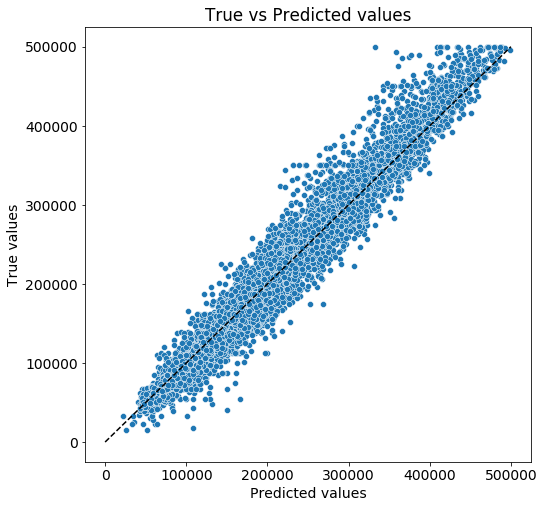

In [ ]:
y_train_preds = final_model.predict(X_train)
evaluate_preds(np.squeeze(y_train.values), y_train_preds)

R2:	0.808
RMSE:	43334.198
MSE:	1877852719.831


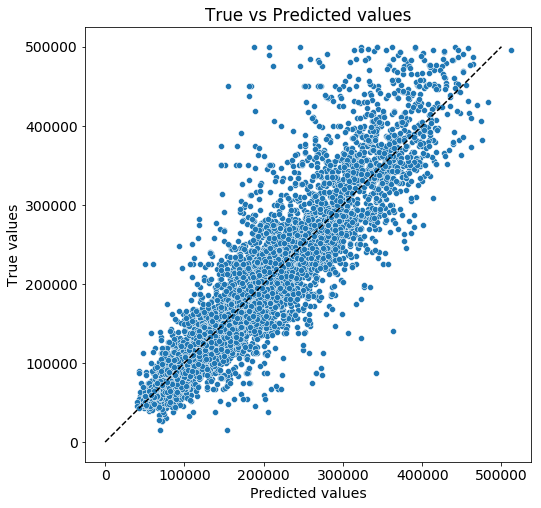

In [ ]:
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds, save=True)

# Шаг 7.* Анализ прогнозов <a class='anchor' id='pred'>

**Важность признаков**

In [ ]:
final_model.feature_importances_

array([0.11740274, 0.11389393, 0.04085088, 0.02800152, 0.02582458,
       0.03693123, 0.01997633, 0.44046009, 0.00364721, 0.16361846,
       0.00139774, 0.00799528])

In [ ]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

**Топ-3 фичи**

In [ ]:
feature_importances.head(3)

,feature_name,importance
7,median_income,0.440460
9,INLAND,0.163618
0,longitude,0.117403


**Худшие 3 фичи**

In [ ]:
feature_importances.tail(3)

,feature_name,importance
11,NEAR OCEAN,0.007995
8,<1H OCEAN,0.003647
10,NEAR BAY,0.001398


In [ ]:
feature_importances.to_csv(REPORTS_FILE_PATH + 'feature_importances.csv', index=False)

Почему в продакшн features_importance не достаточен?

https://habr.com/ru/post/550978/

# Шаг 8. Сохранение модели <a class='anchor' id='save'>

In [ ]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

In [ ]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

In [ ]:
with open(MODEL_FILE_PATH, 'rb') as file:
    my_model = pickle.load(file)
    
my_model

GradientBoostingRegressor(criterion='mse', max_depth=7, min_samples_leaf=10,
                          n_estimators=400, random_state=42)

In [ ]:
import sklearn
print(sklearn.__version__)

0.23.2


In [ ]:
pip freeze

# Обобщение  <a class='anchor' id='full'>

----

## $$Метрики$$
<img src='images/classif&regr.png'>

In [ ]:
from sklearn.ensemble import BaggingRegressor, VotingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

x = [[1, 2, 3], [1, 2, 3], [1, 2, 3]]
y = [0, 10, 15]
knn = KNeighborsRegressor(n_neighbors=1)
c = BaggingRegressor(knn, base_estimator=100)
c.fit(x, y)
c.predict(x)

array([5., 5., 5.])

[Машинное обучение для людей](https://zen.yandex.ru/media/id/5c228ab268a70a00adaf792a/mashinnoe-obuchenie-dlia-liudei-5c23782132121100a94a4417)
<img src=https://avatars.mds.yandex.net/get-zen_doc/1056701/pub_5c23782132121100a94a4417_5c2378bab8997d00a95fbbcc/scale_2400 width=800px>

## Курсовая
**Требования к курсовому:**

Нужно будет оформить ноутбук с основными этапами:
1. подготовка данных
    * анализ
    * визуализация
    * обработка выбросов
    * обработка пропусков
    * генерация фичей
2. обучение модели
3. проверка качества модели

Так же надо отправить файл с предсказаниями на kaggle и на private leaderboard получить больше 0.6

Данные для курсового можно брать отсюда https://www.kaggle.com/t/b4c9382d4f934176af9fe860b1976528 (вкладка data)


________________________
За шаблон оформления курсовой можно взять ноутбук, который будем разбирать на уроке 10: https://www.kaggle.com/julichitai/baseline


*Что обязательно стоит попробовать:*
1. Тщательный анализ данных
2. Поиск странных значений
3. Предобработка данных
4. Генерация разнообразных признаков
5. Разные модели и их разные гиперпараметры

*Что не стоит пробовать:*
1. Кластеризация
2. Модели понижения размерности